In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict as odict
import numpy as np
from tqdm.notebook import tqdm

import math
import torch
import torch.nn as nn

from utils import ssv
from generator import Generator
from torchsummaryX import summary
from clevr_dataset import CLEVRDataset, collate_fn
from ssv import VPNet, VPAwareSynthesizer

import matplotlib.pyplot as plt

In [3]:
import torchvision as tv

def to_pil_grid(batch):
    return tv.transforms.functional.to_pil_image(tv.utils.make_grid(batch))

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
%%time
dataset = CLEVRDataset('/storage1/datasets/CLEVR_v1.0/', 'train', image_sizes=((128, 128),))

CPU times: user 9.89 s, sys: 966 ms, total: 10.9 s
Wall time: 10.8 s


In [83]:
def discriminator_loss(real, fake, style_real=None, style_fake=None):
    real_loss = nn.functional.binary_cross_entropy_with_logits(real, torch.ones_like(real), reduction='none')
    fake_loss = nn.functional.binary_cross_entropy_with_logits(fake, torch.zeros_like(fake), reduction='none')
    # total_disc_loss = torch.cat((real_loss, fake_loss), 0)

    #if style_real:
    #   total_disc_loss = total_disc_loss + style_loss(style_real, "ones")
    #if style_fake:
    #    total_disc_loss = total_disc_loss + style_loss(style_fake, "zeros")

    return real_loss, fake_loss

def generator_loss(generated, style_fake=None):
    total_g_loss = nn.functional.binary_cross_entropy_with_logits(generated, torch.ones_like(generated), reduction='none')
    #if style_fake:
    #    total_g_loss = total_g_loss + style_loss(style_fake, "ones")

    return total_g_loss

def az_to_vp(azimuth):
    cos_azs = torch.cos(azimuth)
    sin_azs = torch.sin(azimuth)

    ccss_az = torch.cat((cos_azs ** 2, sin_azs ** 2), 2)

    sign_cls_az = (
        (((cos_azs >= 0) & (sin_azs >= 0)) * 0)
        + (((cos_azs >= 0) & (sin_azs < 0)) * 1)
        + (((cos_azs < 0) & (sin_azs >= 0)) * 2)
        + (((cos_azs < 0) & (sin_azs < 0)) * 3)
    )
    sign_cls_az = sign_cls_az.type(torch.long).squeeze(-1)
    
    return {'ccss_a': ccss_az, 'sign_a': sign_cls_az}

def get_topk_values_and_complement(scores, k=10):
    (
        (topk_p_values, topk_p_indices),
        topk_complement_indices,
    ) = ssv.get_topk_and_complement_indices(scores, k)
    return topk_p_values, topk_p_indices, (topk_complement_indices, scores[topk_complement_indices].view(scores.size(0), -1))

def sample_topk_objects_and_complement(probs=None, logits=None, hard=True, k=10, temperature=1):
    sample, _ = ssv.sample_bernoulli(logits=logits, probs=probs, temperature=temperature)
    topk_p_values, topk_p_indices, topk_complement = get_topk_values_and_complement(sample)
    if hard:
        topk_p_values = ssv.st_trick(topk_p_values)
    return topk_p_values, topk_p_indices, topk_complement

def additive_normal_noise(t, pct=0.5, mean=0, std=0.01):
    gate = torch.rand_like(t) < pct
    return t + (gate * torch.empty_like(t).normal_(mean, std))

def mult_normal_noise(t, pct=0.5, mean=0, std=1):
    gate = torch.rand(*t.size()[:-1], 1, device=t.device) < pct
    return (~gate * t) + (gate * torch.empty_like(t).normal_(mean, std))

def mult_uniform_noise(t, pct=0.5, low=5, high=5):
    gate = torch.rand(*t.size()[:-1], 1, device=t.device) < pct
    return (~gate * t) + (gate * torch.empty_like(t).uniform_(low, high))

def get_scene_decomposition(inp, disc, disc_noise_thresh=0.1):
    if disc_noise_thresh > 0.0:
        noise = torch.empty_like(inp).normal_(0, 0.01) * (torch.rand(inp.size(0), 1, 1, 1, device=inp.device) < disc_noise_thresh)
    else:
        noise = 0
    pred = disc(inp + noise)
    
    return pred

In [89]:
torch.randn(1, 10, 2).chunk(2, -1)[0].size()

torch.Size([1, 10, 1])

In [96]:
def scene_index_select(scene, indices):
    vp = {}
    vp['logprob_xxyy'] = {
        'a': scene['fg']['logprob_xxyy']['a'].gather(
            1, ssv.expand_indices(
                indices,
                scene['fg']['logprob_xxyy']['a'].size(-1),
            ))}
    vp['sign_x_y'] = {
        'a': scene['fg']['sign_x_y']['a'].gather(
            1, ssv.expand_indices(
                indices,
                scene['fg']['sign_x_y']['a'].size(-1),
            ))}
    scale = scene['fg']['scale'].gather(1, ssv.expand_indices(indices, 1))
    tx, tz = scene['fg']['txtz'].gather(1, ssv.expand_indices(indices, 2)).chunk(2, -1)
    z_fg = scene['fg']['z_fg'].gather(1, ssv.expand_indices(indices, scene['fg']['z_fg'].size(-1)))
    
    return vp, scale, tx, tz, z_fg

def sample_topk_decomposition(scene, k=10, hard=True, temperature=1):
    topk_p_values, topk_p_indices, logits_complement = sample_topk_objects_and_complement(
        logits=scene['fg']['presence_logits'],
        hard=hard,
        k=k,
        temperature=temperature,
    )
    topk_p_values = topk_p_values.unsqueeze(-1)
    vp, scale, tx, tz, z_fg = scene_index_select(scene, topk_p_indices)
    vp['logprob_xxyy']['a'] = vp['logprob_xxyy']['a'] * topk_p_values
    vp['sign_x_y']['a'] = vp['sign_x_y']['a'] * topk_p_values
    scale = scale * topk_p_values
    
    tx, tz = tx * topk_p_values, tz * topk_p_values
    z_fg = z_fg * topk_p_values
    z_bg = scene['bg']['z_bg']
    z_bg = z_bg.view(z_bg.size(0), 1, z_bg.size(-1))
    
    return {
        'topk_p_values': topk_p_values,
        'topk_p_indices': topk_p_indices,
        'logits_complement': logits_complement,
        'vp': vp,
        'scale': scale,
        'tx': tx,
        'tz': tz,
        'z_fg': z_fg,
        'z_bg': z_bg,
    }

def get_topk_decomposition(scene, k=10):
    topk_p_values, topk_p_indices, logits_complement = get_topk_values_and_complement(
        logits=scene['fg']['presence_logits'],
        temperature=temperature,
    )
    vp, scale, tx, tz, z_fg = scene_index_select(scene, topk_p_indices)
    z_bg = scene['bg']['z_bg']
    z_bg = z_bg.view(z_bg.size(0), 1, z_bg.size(-1))
    
    return {
        'topk_p_values': topk_p_values,
        'topk_p_indices': topk_p_indices,
        'logits_complement': logits_complement,
        'vp': vp,
        'scale': scale,
        'tx': tx,
        'tz': tz,
        'z_fg': z_fg,
        'z_bg': z_bg,
    }

In [100]:
def recon_forward(inp, disc, gen, noise_thresh=0.1):
    bsz = inp.size(0)
    real_pred = get_scene_decomposition(inp, disc, noise_thresh)

    sampled_real_scene = sample_topk_decomposition(real_pred)
    real_vp_pred = disc.compute_vp_pred(sampled_real_scene['vp'])
    azimuth = real_vp_pred['a'].view(bsz, -1, 1)
    scale = sampled_real_scene['scale']
    tx = sampled_real_scene['tx']
    tz = sampled_real_scene['tz']
    z_fg = sampled_real_scene['z_fg']
    z_bg = sampled_real_scene['z_bg']
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    
    recon = gen(z_bg, z_fg, view_in_fg=fg_view)
    recon_loss = nn.functional.binary_cross_entropy_with_logits(recon, inp, reduction='none')
    
    return recon_loss, (inp, recon)

def recon_step(inp, disc, gen, d_opt, g_opt):
    recon_loss, (_, recon) = recon_forward(inp, disc, gen)
    _recon_loss = recon_loss.mean()
    _recon_loss.backward()
    d_opt.step()
    g_opt.step()
    d_opt.zero_grad()
    g_opt.zero_grad()
    
    return _recon_loss, recon

In [112]:
bsz = 8
loader = torch.utils.data.DataLoader(dataset, batch_size=bsz, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

vpnet = VPNet(instance_norm=True).to(device)
generator = Generator().to(device)

d_opt = torch.optim.Adam(vpnet.parameters(), lr=1e-4, betas=(0.5, 0.999))
g_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))

n_steps = 3000
pbar = tqdm(range(n_steps))

for i in pbar:
    
    ## DISCRIMINATOR
    d_loss, (z_bg, z_fg, view_in_fg) = discriminator_forward(
        inp,
        vpnet,
        generator,
        gen_noise_thresh=0.0,
    )
    _d_loss = d_loss[0].mean() + d_loss[1].mean()
    _d_loss.backward()
    d_opt.step()
    d_opt.zero_grad()
    g_opt.zero_grad()
    
    ## GENERATOR
    recon = generator(z_bg, z_fg, view_in_fg=view_in_fg)
    fake_vp = vpnet(torch.sigmoid(recon) + torch.empty_like(inp).normal_(0, 0.01))
    fake_is_real = fake_vp['bg']['is_real']
    g_loss = generator_loss(fake_is_real)
    g_loss = g_loss.mean()
    g_loss.backward()
    g_opt.step()
    g_opt.zero_grad()
    d_opt.zero_grad()
    
    pbar.set_postfix(
        # recon_loss=_recon_loss.item(),
        g_loss=g_loss.item(),
        d_loss=_d_loss.item(),
    )

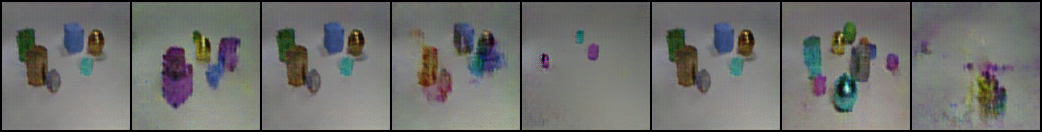

In [115]:
to_pil_grid(torch.sigmoid(recon).detach().cpu())

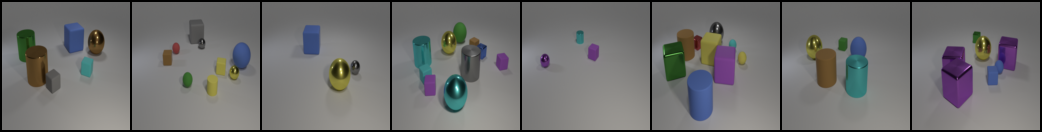

In [116]:
to_pil_grid(inp.cpu())

In [108]:
def discriminator_forward(inp, disc, gen, disc_noise_thresh=0.1, gen_noise_thresh=0.5, k=10):
    bsz = inp.size(0)
    real_pred = get_scene_decomposition(inp, disc, disc_noise_thresh)
    real_is_real = real_pred['bg']['is_real']
    
    sampled_real_scene = sample_topk_decomposition(real_pred)
    real_vp_pred = disc.compute_vp_pred(sampled_real_scene['vp'])
    azimuth = real_vp_pred['a'].view(bsz, k, 1)
    scale = sampled_real_scene['scale']
    tx = sampled_real_scene['tx']
    tz = sampled_real_scene['tz']
    z_fg = sampled_real_scene['z_fg'].detach()
    z_bg = sampled_real_scene['z_bg'].detach()
    
    if gen_noise_thresh > 0:
        azimuth = mult_uniform_noise(azimuth, gen_noise_thresh, low=-math.pi/4, high=math.pi/4)
        scale = additive_normal_noise(sampled_real_scene['scale'], gen_noise_thresh)
        tx = additive_normal_noise(sampled_real_scene['tx'], gen_noise_thresh)
        tz = additive_normal_noise(sampled_real_scene['tz'], gen_noise_thresh)
        z_fg = mult_normal_noise(sampled_real_scene['z_fg'], gen_noise_thresh)
        z_bg = mult_normal_noise(sampled_real_scene['z_bg'], gen_noise_thresh)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    view_in_fg = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1).detach()
    with torch.no_grad():
        recon = gen(z_bg, z_fg, view_in_fg=view_in_fg)
    
    fake_pred = get_scene_decomposition(torch.sigmoid(recon.detach()), disc, disc_noise_thresh)
    fake_is_real = fake_pred['bg']['is_real']
    d_loss = discriminator_loss(real_is_real, fake_is_real)
    
    return d_loss, (z_bg, z_fg, view_in_fg)

In [9]:
def generator_decomposition_forward(inp, disc, gen, disc_noise_thresh=0.1, gen_noise_thresh=0.5):
    disc_noise_thresh = 0.1
    if disc_noise_thresh > 0.0:
        noise = torch.empty_like(inp).normal_(0, 0.01) * (torch.rand(inp.size(0), 1, 1, 1, device=inp.device) < disc_noise_thresh)
    else:
        noise = 0
    with torch.no_grad():
        vps = disc(inp + noise)

    topk_p_values, topk_p_indices, logits_complement = sample_objects_and_get_complement(logits=vps['fg']['presence_logits'], hard=True, k=10)

    topk_vps = {'vp': {}}
    topk_vps['scale'] = vps['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1))
    topk_vps['txtz'] = vps['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2))
    topk_vps['z_fg'] = vps['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['z_fg'].size(-1))) * topk_p_values.unsqueeze(-1)
    topk_vps['vp']['logprob_xxyy'] = {'a': vps['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['logprob_xxyy']['a'].size(-1)))}
    topk_vps['vp']['sign_x_y'] = {'a': vps['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['sign_x_y']['a'].size(-1)))}
    vp = disc.compute_vp_pred(topk_vps['vp'])

    azimuth = vp['a'].unsqueeze(-1)
    scale = topk_vps['scale']
    tx, tz = topk_vps['txtz'].chunk(2, -1)
    z_fg = topk_vps['z_fg']
    z_bg = vps['bg']['z_bg']

    if gen_noise_thresh > 0:
        print('adding generator noise ')
        az_gate = torch.rand_like(azimuth) < gen_noise_thresh
        azimuth = azimuth * ~az_gate + az_gate * torch.empty_like(azimuth).uniform_(-math.pi/4, math.pi/4)
        scale_gate = torch.rand_like(scale) < gen_noise_thresh
        scale = scale + scale_gate * torch.empty_like(scale).normal_(0, 0.01)
        tx_gate = torch.rand_like(tx) < gen_noise_thresh
        tx = tx + tx_gate * torch.empty_like(tx).normal_(0, 0.01)
        tz_gate = torch.rand_like(tz) < gen_noise_thresh
        tz = tz + tz_gate * torch.empty_like(tz).normal_(0, 0.01)
    
    vp = az_to_vp(azimuth)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)

    z_fg_gate = torch.rand(*z_fg.size()[:-1], 1, device=z_fg.device) < gen_noise_thresh
    z_fg = (~z_fg_gate * z_fg) + (z_fg_gate * torch.randn_like(z_fg))
    z_bg_gate = torch.rand(*z_bg.size()[:-1], 1, device=z_bg.device) < gen_noise_thresh
    z_bg = (~z_bg_gate * z_bg) + (z_bg_gate * torch.randn_like(z_bg))

    recon = gen(z_bg.detach(), z_fg.detach(), view_in_fg=fg_view.detach())
    if disc_noise_thresh > 0.0:
        noise = torch.empty_like(recon).normal_(0, 0.01) * (torch.rand(recon.size(0), 1, 1, 1, device=recon.device) < disc_noise_thresh)
    else:
        noise = 0
    vps2 = disc(torch.sigmoid(recon) + noise)

    topk_p_values2 = torch.sigmoid(vps2['fg']['presence_logits'].gather(1, topk_p_indices))
    topk_vps2 = {'vp': {}}
    topk_vps2['scale'] = vps2['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1))
    topk_vps2['txtz'] = vps2['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2))
    tx2, tz2 = topk_vps2['txtz'].chunk(2, -1)
    topk_vps2['z_fg'] = vps2['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, vps2['fg']['z_fg'].size(-1))) * topk_p_values2.unsqueeze(-1)
    topk_vps2['vp']['logprob_xxyy'] = {'a': vps2['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps2['fg']['logprob_xxyy']['a'].size(-1)))}
    topk_vps2['vp']['sign_x_y'] = {'a': vps2['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps2['fg']['sign_x_y']['a'].size(-1)))}
    z_bg2 = vps2['bg']['z_bg']

    bce_l = torch.nn.BCEWithLogitsLoss(reduction='none')
    bce = torch.nn.BCELoss(reduction='none')
    soft_l1 = torch.nn.SmoothL1Loss(reduction='none')

    vp_loss = disc.compute_vp_loss(topk_vps2['vp'], vp) ##
    vp_loss_sign_a = vp_loss['sign_a'] * topk_p_values
    vp_loss_ccss_a = vp_loss['ccss_a'] * topk_p_values.unsqueeze(-1).unsqueeze(-1)
    presence_loss = bce_l(vps2['fg']['presence_logits'], torch.sigmoid(vps['fg']['presence_logits']))
    scale_loss = bce(topk_vps2['scale'], scale) * topk_p_values.unsqueeze(-1)
    tx_loss = bce((tx2 + 1) / 2, (tx + 1) / 2)* topk_p_values.unsqueeze(-1)
    tz_loss = bce((tz2 + 1) / 2, (tz + 1) / 2)* topk_p_values.unsqueeze(-1)
    z_fg_loss = soft_l1(topk_vps2['z_fg'], z_fg)
    z_bg_loss = soft_l1(z_bg2, z_bg)

    fake_is_real = vps2['bg']['is_real']
    g_loss = generator_loss(fake_is_real)

    return {
        'g_loss': g_loss,
        'vp_loss_sign_a': vp_loss_sign_a,
        'vp_loss_ccss_a': vp_loss_ccss_a,
        'presence_loss': presence_loss,
        'scale_loss': scale_loss,
        'tx_loss': tx_loss,
        'tz_loss': tz_loss,
        'z_fg_loss': z_fg_loss,
        'z_bg_loss': z_bg_loss,
    }, (fake_is_real, recon)

In [56]:
gen_loss

{'g_loss': tensor([[3.7493],
         [3.8684],
         [3.8780],
         [3.8640]], device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'vp_loss_sign_a': tensor([[4.1493, 0.3364, 1.5819, 0.9584, 0.9276, 1.5164, 0.8094, 0.6977, 0.0000,
          0.0000],
         [1.4127, 3.2838, 0.9213, 1.0670, 0.5138, 3.4309, 4.4669, 0.5399, 0.2038,
          1.0828],
         [1.2744, 0.4425, 1.9240, 1.4525, 1.9118, 2.4037, 2.2241, 1.6308, 0.4329,
          0.0000],
         [2.0365, 1.5342, 0.8868, 0.7533, 0.8017, 1.0651, 0.9602, 1.7126, 3.0894,
          0.5768]], device='cuda:0', grad_fn=<MulBackward0>),
 'vp_loss_ccss_a': tensor([[[[1.4000]],
 
          [[0.8323]],
 
          [[0.6163]],
 
          [[1.0250]],
 
          [[0.0811]],
 
          [[0.7102]],
 
          [[0.7251]],
 
          [[0.1162]],
 
          [[0.0000]],
 
          [[0.0000]]],
 
 
         [[[0.2732]],
 
          [[2.5462]],
 
          [[0.9142]],
 
          [[0.5772]],
 
          [[0.694

In [72]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

vpnet = VPNet(instance_norm=True).to(device)
generator = Generator().to(device)

d_opt = torch.optim.Adam(vpnet.parameters(), lr=1e-4)
g_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

n_steps = 3000
pbar = tqdm(range(n_steps))
for i in pbar:
    # recon_loss, (_inp, recon) = recon_forward(inp, vpnet, generator)
    # _recon_loss = recon_loss.sum((1, 2, 3)).mean() * 1e-3
    # _recon_loss = recon_loss.mean()
    # _recon_loss.backward()
    disc_loss, _ = discriminator_forward(inp, vpnet, generator, gen_noise_thresh=0)
    _disc_loss = disc_loss[0].sum(1).mean() + disc_loss[1].sum(1).mean()
    _disc_loss.backward()
    # nn.utils.clip_grad_norm_(vpnet.parameters(), 1)
    d_opt.step()
    d_opt.zero_grad()
    g_opt.zero_grad()
    
    gen_dec_loss, (fake_is_real, recon) = generator_decomposition_forward(inp, vpnet, generator, gen_noise_thresh=0)
    _gen_loss = gen_dec_loss['g_loss'].mean()
    _gen_loss.backward()
    # nn.utils.clip_grad_norm_(generator.parameters(), 1)
    g_opt.step()
    g_opt.zero_grad()
    d_opt.zero_grad()
    
    pbar.set_postfix(
        d_loss=_disc_loss.item(),
        g_loss=_gen_loss.item(),
    )

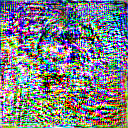

In [70]:
to_pil_grid(torch.sigmoid(recon).detach().cpu())

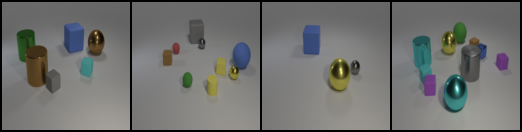

In [54]:
to_pil_grid(inp.cpu())

In [17]:
from torchvision.models import resnet18

In [32]:
resnet = nn.Sequential(*list(resnet18(pretrained=True, progress=True).to(device).children())[:-4])
resnet(inp).size()

torch.Size([16, 128, 16, 16])

In [14]:
bsz = 4
loader = torch.utils.data.DataLoader(dataset, batch_size=bsz, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

vpnet = VPNet(instance_norm=True).to(device)
generator = Generator().to(device)

d_opt = torch.optim.Adam(vpnet.parameters(), lr=1e-4, betas=(0.5, 0.999))
g_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))

n_steps = 1000
pbar = tqdm(range(n_steps))

for i in pbar:
    
    # real_vp = vpnet(inp + torch.empty_like(inp).normal_(0, 0.01))
    # real_is_real = real_vp['bg']['is_real']
    # topk_p_values, topk_p_indices, logits_complement = sample_objects_and_get_complement(logits=real_vp['fg']['presence_logits'], hard=True, k=10)
    
    # topk_vps = {'vp': {}}
    # topk_vps['scale'] = real_vp['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1))
    # topk_vps['txtz'] = real_vp['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2))
    # topk_vps['z_fg'] = real_vp['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, real_vp['fg']['z_fg'].size(-1))) * topk_p_values.unsqueeze(-1)
    # topk_vps['vp']['logprob_xxyy'] = {'a': real_vp['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, real_vp['fg']['logprob_xxyy']['a'].size(-1)))}
    # topk_vps['vp']['sign_x_y'] = {'a': real_vp['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, real_vp['fg']['sign_x_y']['a'].size(-1)))}
    # vp = vpnet.compute_vp_pred(topk_vps['vp'])

    # azimuth = vp['a'].unsqueeze(-1)
    # scale = topk_vps['scale']
    # tx, tz = topk_vps['txtz'].chunk(2, -1)
    # z_fg = topk_vps['z_fg']
    # z_bg = real_vp['bg']['z_bg']
    
    # vp = az_to_vp(azimuth)
    # elevation = tilt = ty = torch.zeros_like(azimuth)
    # fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    
    # with torch.no_grad():
        # recon = generator(z_bg, z_fg, view_in_fg=fg_view)
    # fake_vp = vpnet(torch.sigmoid(recon).detach() + torch.empty_like(inp).normal_(0, 0.01))
    # fake_is_real = fake_vp['bg']['is_real']
    
    # d_loss = discriminator_loss(real_is_real, fake_is_real)
    
    
    d_loss = d_loss[0].mean() + d_loss[1].mean()
    d_loss.backward()
    d_opt.step()
    d_opt.zero_grad()
    g_opt.zero_grad()
    
    ### GENERATOR TURN
    
    with torch.no_grad():
        real_vp = vpnet(inp)
    topk_p_values, topk_p_indices, logits_complement = sample_objects_and_get_complement(logits=real_vp['fg']['presence_logits'], hard=True, k=10)
    
    topk_vps = {'vp': {}}
    topk_vps['scale'] = real_vp['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1))
    topk_vps['txtz'] = real_vp['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2))
    topk_vps['z_fg'] = real_vp['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, real_vp['fg']['z_fg'].size(-1))) * topk_p_values.unsqueeze(-1)
    topk_vps['vp']['logprob_xxyy'] = {'a': real_vp['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, real_vp['fg']['logprob_xxyy']['a'].size(-1)))}
    topk_vps['vp']['sign_x_y'] = {'a': real_vp['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, real_vp['fg']['sign_x_y']['a'].size(-1)))}
    vp = vpnet.compute_vp_pred(topk_vps['vp'])

    azimuth = vp['a'].unsqueeze(-1)
    scale = topk_vps['scale']
    tx, tz = topk_vps['txtz'].chunk(2, -1)
    z_fg = topk_vps['z_fg']
    z_bg = real_vp['bg']['z_bg']
    
    vp = az_to_vp(azimuth)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    
    recon = generator(z_bg, z_fg, view_in_fg=fg_view)
    fake_vp = vpnet(torch.sigmoid(recon) + torch.empty_like(inp).normal_(0, 0.01))
    fake_is_real = fake_vp['bg']['is_real']
    
    g_loss = generator_loss(fake_is_real)
    g_loss = g_loss.mean()
    g_loss.backward()
    g_opt.step()
    g_opt.zero_grad()
    d_opt.zero_grad()
    
    pbar.set_postfix(
        d_loss=d_loss.item(),
        g_loss=g_loss.item(),
    )

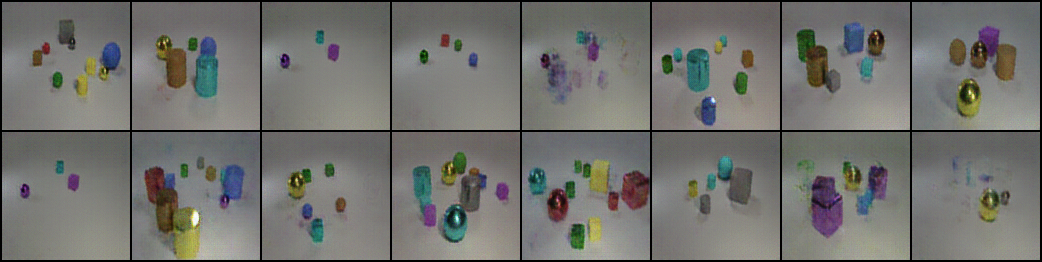

In [15]:
to_pil_grid(torch.sigmoid(recon).detach().cpu())

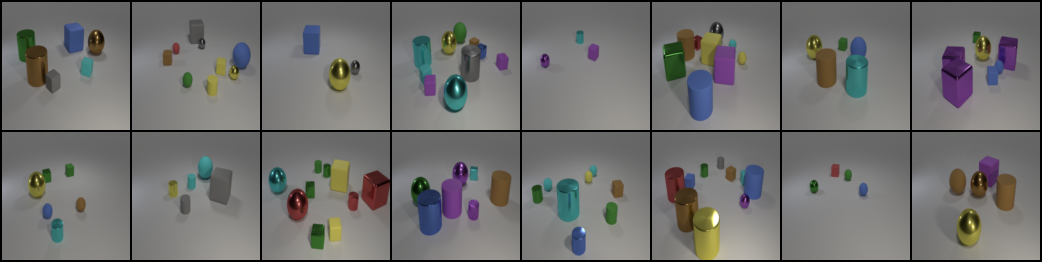

In [16]:
to_pil_grid(inp.cpu())

In [41]:
torch.sigmoid(vps['fg']['presence_logits'])

tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)

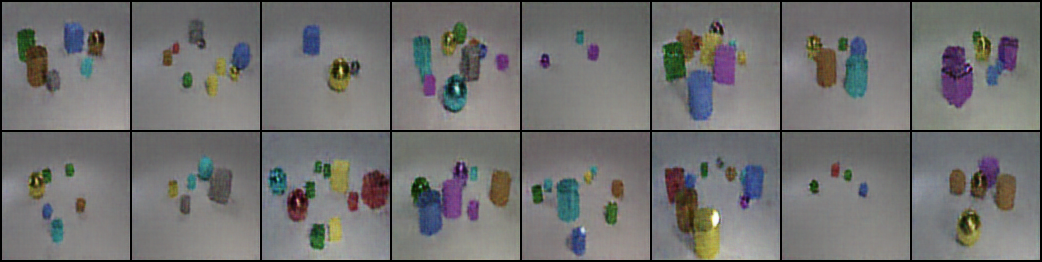

In [13]:
to_pil_grid(recon2.detach().cpu())

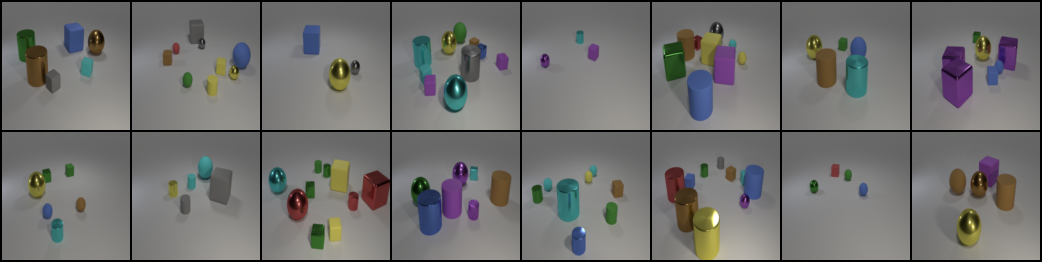

In [159]:
to_pil_grid(inp.detach().cpu())

In [10]:
def sample_objects_and_get_complement(probs=None, logits=None, hard=True, k=10):
    sample, _ = ssv.sample_bernoulli(logits=logits, probs=probs)
    (
        (topk_p_values, topk_p_indices),
        topk_complement,
    ) = ssv.get_topk_and_complement_indices(sample, k)
    if hard:
        topk_p_values = ssv.st_trick(topk_p_values)
    return topk_p_values, topk_p_indices, (probs or logits)[topk_complement].view(sample.size(0), -1)

In [ ]:
def discriminator_forward(inp, disc, gen, disc_noise_thresh=0.1, gen_noise_thresh=0.5, k=10):
    bsz = inp.size(0)
    real_pred = get_scene_decomposition(inp, disc, disc_noise_thresh)
    real_is_real = real_pred['bg']['is_real']
    
    topk_p_values, topk_p_indices, logits_complement = sample_objects_and_get_complement(
        logits=real_pred['fg']['presence_logits'],
        hard=True,
        k=k,
    )

    sampled_real_scene = sample_topk_decomposition(scene)
    
    # real_vp = 
    # real_vp['logprob_xxyy'] = {
    #     'a': real_pred['fg']['logprob_xxyy']['a'].gather(
    #         1, ssv.expand_indices(
    #             topk_p_indices,
    #             real_pred['fg']['logprob_xxyy']['a'].size(-1),
    #         ))}
    # real_vp['sign_x_y'] = {
    #     'a': real_pred['fg']['sign_x_y']['a'].gather(
    #         1, ssv.expand_indices(
    #             topk_p_indices,
    #             real_pred['fg']['sign_x_y']['a'].size(-1),
    #         ))}
    # scale = real_pred['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1))
    # txtz = real_pred['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2))
    # z_fg = real_pred['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['z_fg'].size(-1)))
    
    # real_vp['logprob_xxyy'] = real_vp['logprob_xxyy'] * topk_p_values.unsqueeze(-1)
    # real_vp['sign_x_y'] = real_vp['sign_x_y'] * topk_p_values.unsqueeze(-1)
    # scale = scale * topk_p_values.unsqueeze(-1)
    # txtz = txtz * topk_p_values.unsqueeze(-1)
    # z_fg = z_fg * topk_p_values.unsqueeze(-1)
    
    real_vp_pred = disc.compute_vp_pred(sampled_real_scene['vp'])
    azimuth = real_vp_pred['a'].view(bsz, k, 1)
    # tx, tz = txtz.chunk(2, -1)
    # z_bg = real_pred['bg']['z_bg']
    
    # topk_vps['scale'] = vps['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1)).detach()
    # topk_vps['txtz'] = vps['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2)).detach()
    # topk_vps['z_fg'] = vps['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['z_fg'].size(-1))).detach() * topk_p_values.unsqueeze(-1).detach()
    # topk_vps['vp']['logprob_xxyy'] = {'a': vps['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['logprob_xxyy']['a'].size(-1))).detach()}
    # topk_vps['vp']['sign_x_y'] = {'a': vps['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['sign_x_y']['a'].size(-1))).detach()}
    # vp = disc.compute_vp_pred(topk_vps['vp'])
    # azimuth = vp['a'].unsqueeze(-1)
    # scale = topk_vps['scale']
    # tx, tz = topk_vps['txtz'].chunk(2, -1)
    # z_fg = topk_vps['z_fg']
    # z_bg = vps['bg']['z_bg']

    if gen_noise_thresh > 0:
        # print('Adding generator noise')
        # az_gate = torch.rand_like(azimuth) < gen_noise_thresh
        # azimuth = azimuth * ~az_gate + az_gate * torch.empty_like(azimuth).uniform_(-math.pi/4, math.pi/4)
        azimuth = mult_uniform_noise(azimuth, gen_noise_thresh, low=-math.pi/4, high=math.pi/4)
        # scale_gate = torch.rand_like(scale) < gen_noise_thresh
        # scale = scale + scale_gate * torch.empty_like(scale).normal_(0, 0.01)
        scale = additive_normal_noise(sampled_real_scene['scale'], gen_noise_thresh)
        # tx_gate = torch.rand_like(tx) < gen_noise_thresh
        # tx = tx + tx_gate * torch.empty_like(tx).normal_(0, 0.01)
        tx = additive_normal_noise(sampled_real_scene['tx'], gen_noise_thresh)
        # tz_gate = torch.rand_like(tz) < gen_noise_thresh
        # tz = tz + tz_gate * torch.empty_like(tz).normal_(0, 0.01)
        tz = additive_normal_noise(sampled_real_scene['tz'], gen_noise_thresh)
        # z_fg_gate = torch.rand(*z_fg.size()[:-1], 1, device=z_fg.device) < gen_noise_thresh
        # z_fg = (~z_fg_gate * z_fg) + (z_fg_gate * torch.randn_like(z_fg))
        z_fg = mult_normal_noise(sampled_real_scene['z_fg'], gen_noise_thresh)
        # z_bg_gate = torch.rand(*z_bg.size()[:-1], 1, device=z_bg.device) < gen_noise_thresh
        # z_bg = (~z_bg_gate * z_bg) + (z_bg_gate * torch.randn_like(z_bg))
        z_bg = mult_normal_noise(sampled_real_scene['z_bg'], gen_noise_thresh)
    
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    with torch.no_grad():
        recon = gen(z_bg.detach(), z_fg.detach(), view_in_fg=fg_view.detach())
    
    fake_pred = get_scene_decomposition(torch.sigmoid(recon.detach()), disc, disc_noise_thresh)
    
    # if disc_noise_thresh > 0.0:
    #     noise = torch.empty_like(recon).normal_(0, 0.01) * (torch.rand(recon.size(0), 1, 1, 1, device=recon.device) < disc_noise_thresh)
    # else:
    #     noise = 0
    # fake_pred = disc(torch.sigmoid(recon.detach()) + noise)

    fake_is_real = fake_pred['bg']['is_real']
    d_loss = discriminator_loss(real_is_real, fake_is_real)
    
    return d_loss, (z_bg, z_fg, view_in_fg)